# **Multi-targets multi-cameras tracking**

In this Notebook, I implement state-of-the-art Mask R-CNN and DeepSORT in order to proceed indivuduals tracking-by-detection.
The Mask R-CNN model efficiently detects objects within an image and provides a class, a bounding box, a score and a mask for all those objects. The DeepSORT algorithm is able to track those detections through the frames of video stream.

## **Notebook and models preparation**

---

### **Clone the git repository**

In [1]:
!git clone https://github.com/Thomas-Gentilhomme/AI-Project.git

Cloning into 'AI-Project'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 355 (delta 37), reused 39 (delta 19), pack-reused 292
Receiving objects: 100% (355/355), 784.73 MiB | 48.07 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Checking out files: 100% (64/64), done.


### **Useful imports**

In [2]:
import warnings
import os
import sys
import pickle
import random
import math
import numpy as np
import copy
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from time import time
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
%cd AI-Project
# Import utils to load my functions
import functions

/content/AI-Project


### **Preparation for the Mask RCNN model**

In [3]:
%tensorflow_version 1.x
%cd mask_rcnn
warnings.filterwarnings('ignore') 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Load trained dataset configuration
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

%cd ../

TensorFlow 1.x selected.
/content/AI-Project/mask_rcnn


Using TensorFlow backend.


... done downloading pretrained model!
/content/AI-Project


## **Test the Mask RCNN detection model and useful functions**

---

### **Mask-RCCN detection test on a single image**

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

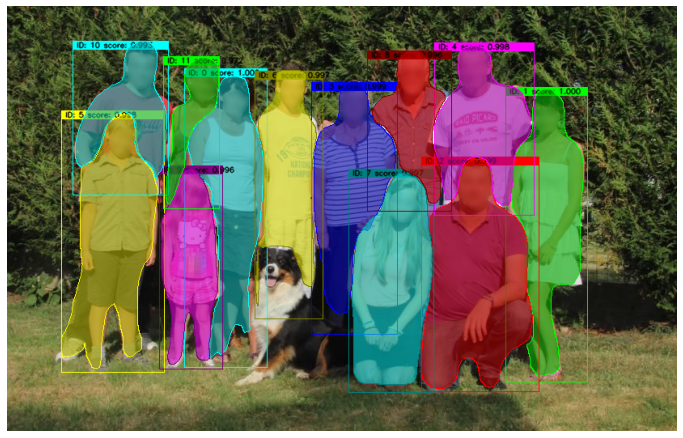

In [ ]:
# Load a test image
image = skimage.io.imread('tests/test_image.jpg')

# Run detection
result = model.detect([image], verbose=0)[0]

# Visualize results
threshold = 0.9
result = functions.update_results(result, threshold)

ids = [i for i in range(len(result['scores']))]

colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128),(0,255,255),(0,255,0),(255,0,0)]

#colors = [(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),
#          (0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0)]

masked_image = functions.draw_without_tracking(image, result['rois'], 
                                                               result['masks'], 
                                                               result['scores'], 
                                                               ids, colors
                                                              )


frame_height, frame_width = image.shape[:2]
_, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.imshow(masked_image.astype(np.uint8))
plt.show()

### **Mask-RCCN detection test on a single video**

In [ ]:
# Test Video Files
#VideoFile = 'tests/test_video1.mp4'
VideoFile = 'tests/test_video2.mp4'

# Set of Available Colors
colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128),(0,255,255),(0,255,0),(255,0,0)]

# Threshold for detection
threshold = 0.8

# Read video 
cap = cv2.VideoCapture(VideoFile)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Prepare Output Video
if VideoFile == 'tests/test_video1.mp4':
    out = cv2.VideoWriter('tests/masked_test_video1_without_tracking.mp4',
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          15, 
                          (frame_width,frame_height)
                         )
elif VideoFile == 'tests/test_video2.mp4':
    out = cv2.VideoWriter('tests/masked_test_video2_without_tracking.mp4',
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          30, 
                          (frame_width,frame_height)
                         )
else :
    print("Error: wrong VideoFile")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
count = 0

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        # The operations on the frame come here        
        frame_result = model.detect([frame], verbose=0)[0]
        frame_result = functions.update_results(frame_result, threshold)
        ids = ['No ID' for i in range(len(frame_result['scores']))]
        masked_frame = functions.draw_without_tracking(frame, 
                                                                       frame_result['rois'], 
                                                                       frame_result['masks'], 
                                                                       frame_result['scores'], 
                                                                       ids, colors
                                                                      )

        # Write the resulting frame in a new video file
        out.write(masked_frame)

        count += 1
        if (count % 10) == 0:
          clear_output(wait=True)
          print('Progression: {:.2%}'.format(count/total_frames))
    else:
        clear_output(wait=True)
        print('Progression: {:.2%}'.format(count/total_frames))
        break

# When everything done, release the capture
out.release()
cap.release()
cv2.destroyAllWindows()

Progression: 100.00%


## **Single video multi-targets detection and tracking**

---



### **Useful imports and parameters initialization**

In [ ]:
%cd deep_sort

# Imports

from detection import Detection
import nn_matching
import preprocessing
from tracker import Tracker
import generate_detections as gdet

# Parameters

VideoFile = 'tests/test_video1.mp4'
#VideoFile = 'tests/test_video2.mp4'
OutputVideo = 'tests/tracked_test_video1.mp4'
#OutputVideo = 'tests/tracked_test_video2.mp4'
rate = 15
#rate = 30

# Set of available colors
colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

#detection_threshold = 0.6      # Threshold for persons detection
detection_threshold = 0.98

model_filename = 'deep_sort/mars-small128.pb'       # DeepSORT encoder weights
max_age = 60  # Memory length of the tracks 
n_init = 5    # Minimum number of consecutive detections to create a Track object
show_masks = False
show_masks_contour = False

%cd ../

### **Useful functions**

Those functions has been moved to the **AI-Project.functions.py** python file. They are the useful functions used in the following models.

### **Model classes**

In this part, I implement the classes used to perform the tracking.

* A class to model the **individuals** on each frame.
* A class to model the used **detector**.
* A class to model the used **tracker**.

#### **Individuals**

This class models all the individuals of each frame. It allows to keep track of their respective ID during the track and to draw them accordingly.

In [4]:
class Individuals():
    '''
    Class used to store the caracteristics of each detected individuals on a frame.
    ----------
    Parameters
    ----------
    dect_rois: array-like
        Coordinates of the detected bounding boxes (rois = Regions of Interest).
    pred_rois: array_like
        Coordinates of the bounding boxes predicted by the Kalman filters if DeepSORT.
    sores: array-like
        Confidence scores to belong to the associated class.
    masks: array-like
        Binary masks of the detected individuals on the associated frame.
    class_ids: array-like
        Class id of the detection according to MS COCO nomenclature (always '1' in our case).
    track_ids: array-like
        Unique ids to identify an individual through the tracking process.
    ids_color: array_like
        List of all available colors to link to an unique individual.
    img: array-like
        The frame associated to these individuals.
    ----------
    Attributes
    ----------
    dect_rois: array-like
        Coordinates of the detected bounding boxes (rois = Regions of Interest).
    pred_rois: array_like
        Coordinates of the bounding boxes predicted by the Kalman filters if DeepSORT.
    scores: array-like
        Confidence scores to belong to the associated class.
    masks: array-like
        Binary masks of the detected individuals on the associated frame.
    class_ids: array-like
        Class id of the detection according to MS COCO nomenclature (always '1' in our case).
    track_ids: array-like
        Unique ids to identify an individual through the tracking process.
    ids_color: array_like
        List of all available colors to link to an unique individual.
    img: array-like
        The frame associated to these individuals.
    '''

    def __init__(self):
        self.dect_rois = []
        self.pred_rois = []
        self.scores = []
        self.masks = []
        self.class_ids = [] 
        self.track_ids = []
        self.ids_color = []
        self.img = []

#### **MaskRCNN**


Class that implements the Mask RCNN model and performs the prediction on a specific frame. Then, it returns the outputs using the **Individuals** class.

In [5]:
class MaskRCNN():
    """
    Create an instance of a MaskRCNN object based on the keras implementation by 
    Matterport: https://github.com/matterport/Mask_RCNN.
    Mask RCNN in an end-to-end detection algorithm. Given an image, it returns a 
    list of object ids and the corresponding boxes, masks and scores.
    This model has been pre-trained on the MS COCO data set.
    ----------
    Parameters
    ----------
    model: MaskRCNN
        The MaskRCNN model.
    threshold: float
        The confidence under which we consider the detection as incorect.
    pretrained_weight_path: string
        Path to used MS COCO pretrained weights for the Mask RCNN deep layers.
    ----------
    Attributes
    ----------
    model: MaskRCNN
        The MaskRCNN model.
    threshold: float
        The confidence under which we consider the detection as incorect.
    individuals: Individuals
        Object that contains all the caracteristics of the detected individuals.
    pretrained_weight_path: string
        Path to used MS COCO pretrained weights for the Mask RCNN deep layers.
    """
    def __init__(self, model, threshold, pretrained_weight_path):
        self.model = model
        self.threshold = threshold
        self.individuals = Individuals()
        self.pretrained_weight_path = pretrained_weight_path

        # Load weights trained on MS-COCO
        self.model.load_weights(self.pretrained_weight_path, by_name=True)
      
    def predict(self, frame, verb=0):
        """
        ----------
        Parameters
        ----------
        frame: array_like
            The image on which the MaskRCNN detector is apply.
        ------
        Return
        ------
        output: dictionnary
            It contains four lists: one for the objects boxe coordinates, one for the 
            objects id, one for the objects score and one for the objects binary mask.
        """

        output = self.model.detect([frame], verbose=verb)[0]
        
        # Keep all objects that are a person with a confidence score above a threshold
        output = functions.update_results(output, self.threshold)

        #TO TO : case where nothing is detected ???

        self.individuals.dect_rois = output['rois']
        self.individuals.masks = output['masks']
        self.individuals.class_ids = output['class_ids']
        self.individuals.scores = output['scores']
        self.individuals.img = frame

        return self.individuals

#### **DeepSORT**

Classe that implements the **DeepSORT** algorithm used to track individuals.
It updates the **track_ids** attributes of the *Individual** object returned by the detector.

In [6]:
class DeepSORT():
    """
    Create an instance of a DeepSORT object based on the implementation by Nicolai 
    Wojke: https://github.com/nwojke/deep_sort.
    The multi-cams adapatation has been inspired by: 
    https://github.com/LeonLok/Multi-Camera-Live-Object-Tracking.
    The idea of this class is to perform a tracking of the detected individuals.
    DeepSORT is a tracking algorithm. It holds a 'track' object for each detected
    individual. Newly created tracks are classified as 'tentative' until enough 
    evidence has been collected. Then, the track state is changed to 'confirmed'. 
    Tracks that are no longer alive are classified as 'deleted' to mark them for 
    removal from the set of active tracks.

    In the initialization, we simply create the tracker object based on cosine metric.
    ----------
    Parameters
    ----------
    colors: array_like
        List of all available colors to link to an unique ID.
    model_filename: string
        DeepSORT encoder weights.
    max_cosine_distance: float
        The matching threshold. Samples with larger distance are considered an invalid 
        match. It is used to associate the detections with the existing tracks.
        Associations with cost larger than this value are disregarded.
    nms_max_overlap: float
        Threshold used in NMS: Non-Max-Suppression.
    nn_budget: 

    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of consecutive detections before the track is confirmed. The
        track state is set to `Deleted` if a miss occurs within the first
        `n_init` frames.
    ----------
    Attributes
    ----------
    colors: array_like
        List of all available colors to link to an unique ID.
    max_age : int
        Maximum number of missed misses before a track is deleted.
    n_init : int
        Number of frames that a track remains in initialization phase.
    nms_max_overlap: float
        Threshold used in NMS: Non-Max-Suppression.
    metric: nn_matching.NearestNeighborDistanceMetric
        A distance metric for measurement-to-track association.
    tracker: Tracker
        This is the multi-target tracker of the Deep Sort Algorithm. It initializes 
        a tracking list and a Kalman filter.
    encoder: ImageEncoder
        ...
    """
    def __init__(self, colors, model_filename, max_iou_distance=0.7, 
                 max_cosine_distance=0.2, nn_budget=None, max_age=30, 
                 nms_max_overlap=1.0, n_init=3):

        self.colors = colors
        self.max_iou_distance = max_iou_distance
        self.max_age = max_age
        self.n_init = n_init
        self.nms_max_overlap = nms_max_overlap 
        self.metric = nn_matching.NearestNeighborDistanceMetric(
            "cosine", max_cosine_distance, nn_budget
            )
        self.tracker = Tracker(self.metric, self.colors, self.max_iou_distance, 
                               self.max_age)
        self.encoder = gdet.create_box_encoder(model_filename, batch_size=1)

    def perform_track(self,frame,individuals):
        '''
        The tracking method. It makes the link between our videos, the outputs of the 
        detector and the used DeepSORT architecture. It allows each identical detection 
        to have a unique ID through the videos.
        ----------
        Parameters
        ----------
        frame: array_like
            The current frame from which we track the individuals.
        output: Individuals
            The output of the detector from which we only kept the individuals with more 
            than a certain threshold confidence score.
        ------
        Return
        ------
        output: Individuals
            The updated output after performing the tracking method. 
        '''
        frame_height, frame_width, _ = frame.shape

        # Generate detections objects from the output of the Mask RCNN Detector.
        '''
        Detection class represents a bounding box detection in a single image.
        To do so, we need to compute the features associated with each box.
        '''
        detections=[]
        # Change bboxes format y1,x1,y2,x2 to match bbox format of DeepSORT x,y,w,h.
        converted_rois = functions.convert_roi_shape(individuals.dect_rois)
        features = self.encoder(frame,converted_rois)
        crops = [functions.crop_box(frame,coord) for coord in individuals.dect_rois]
        for dect_roi, score, feature, crop in zip(converted_rois,individuals.scores,features,crops):
            detections.append(Detection(dect_roi,score,feature,crop)) 
    
        # Run non-maxima suppression. 
            # TO DO : try without NMS (maybe unuseful as already in mask rcnn)
        boxes = np.array([d.tlwh for d in detections])
        scores = np.array([d.confidence for d in detections])
        indices = preprocessing.non_max_suppression(boxes, self.nms_max_overlap, scores)
        detections = [detections[i] for i in indices]

        # Update tracker.
        '''
        tracker.predict() propagates track state distributions one time step forward.

        It is called once every time step (before 'update') and for each track of the 
        tracks list, it propagates the state distribution to the current time step using 
        a Kalman filter prediction step. It also increments each track age.
        '''
        self.tracker.predict()
        '''
        tracker.update(detections) performs the actual measurement update and track 
        management.

        Is starts by runing a cascade matching between all detections and tracks on
        the last 'max_age' time steps. For that, the function splits the track set 
        into 'confirmed' and 'unconfirmed' tracks ('unconfirmed' means either 'tentative' 
        or 'deleted').

        Then it associates the 'confirmed' tracks using appearance features. For that,
        the function computes a cost matrix based on the chosen metric between all 
        tracks and all detection and performs a minimal cost matching using the 
        sklearn.utils.linear_assignment function.

        Then it associates remaining tracks together with 'unconfirmed' tracks using 
        IOU matching (= Computer intersection over union Matching).

        Finally, it updates the track set and the distance metric. For that, it updates
        the matched tracks (by updating the Kalman Filters mean and covariance, by
        adding the detection features to the associated track features and by changing
        'Tentative' state to 'Confirmed' if necessary), it marks as "missed" the tracks 
        that hasn't been associated with any match at the current time step (and deletes 
        them after 'max_age' missed steps) and it initiates a track for the detections 
        that hasn't been associated with any track.
        '''
        self.tracker.update(detections)


        # Update individuals ids, ROIs and colors to be identify.
        total_track = len(self.tracker.tracks)
        individuals.track_ids = np.zeros((total_track))
        individuals.pred_rois = np.zeros((total_track,4))
        individuals.ids_color = np.zeros((total_track,3))
        C = len(self.colors)
        for i, track in enumerate(self.tracker.tracks):
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            individuals.track_ids[i] = track.track_id
            x1, y1, x2, y2 = track.to_tlbr()
            individuals.pred_rois[i] = y1, x1, y2, x2
            individuals.ids_color[i] = track.color #self.colors[i%C]

        return individuals


In [7]:
class Track():
    '''
    This class is end-to-end tracking-by-detection system.
    ----------
    Parameters
    ----------
    detector: MaskRCNN objet
        The used detector object (MaskRCNN).
    tracker: DeepSORT object
        The used tracker object (DeepSORT).
    show_masks: boolean
        Draw masks on output video or not.
    show_masks_contour: boolean
        Draw masks contour on output video or not.
    ----------
    Attributes
    ----------
    detector: MaskRCNN objet
        The used detector object (MaskRCNN).
    tracker: DeepSORT object
        The used tracker object (DeepSORT).
    show_masks: boolean
        Draw masks on output video or not.
    show_masks_contour: boolean
        Draw masks contour on output video or not.
    '''
    def __init__(self, detector, tracker, show_masks, show_masks_contour):
        self.detector = detector
        self.tracker = tracker
        self.show_masks = show_masks
        self.show_masks_contour = show_masks_contour

    def tracking(self, VideoFile, OutputVideo, rate):
        '''
        This function performs the detection and the tracking through a single video file.
        ----------
        Parameters
        ----------
        VideoFile: string
            Path to the used video file.
        OutputVideo: string
            Path to the output video file.
        rate: int
            Output Video frequency.
        -------
        Returns
        -------
        global_times, detecting_times, tracking_times, drawing_times : lists
            Lists containing the time period of each interesting process.
        '''
        cap = cv2.VideoCapture(VideoFile)

        if (cap.isOpened()== False): 
            print("Error opening video stream or file")

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))

        out = cv2.VideoWriter(
            OutputVideo,
            cv2.VideoWriter_fourcc('M','J','P','G'),
            rate,
            (frame_width,frame_height)
            )

        # Take initial time to measure time performance and put it in a list
        time0 = time()
        global_times = [time0]
        detecting_times = []
        tracking_times = []
        drawing_times = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        count = 0

        while(cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            if ret == True:
                #### Operations to perform over each frame ####
                
                # Apply detector to the frame
                time1 = time()
                individuals = self.detector.predict(frame)
                time2 = time()
                detecting_times.append(time2-time1)
                # Apply tracker to the frame
                time1 = time()
                individuals = self.tracker.perform_track(frame,individuals)
                time2 = time()
                tracking_times.append(time2-time1)

                # Create an output image by drawing the corresponding masks over the 
                # detected persons of the frame
                time1 = time()   
                masked_frame = functions.draw_with_tracking(frame, 
                                                    individuals.dect_rois,
                                                    individuals.pred_rois,
                                                    individuals.masks, 
                                                    individuals.scores, 
                                                    individuals.track_ids, 
                                                    individuals.ids_color,
                                                    show_masks=self.show_masks,
                                                    show_masks_contour=self.show_masks_contour,
                                                    roi_thickness = 2,
                                                    mask_thickness = 1
                                                    )
                time2 = time()
                drawing_times.append(time2-time1)
                # Display the resulting frame
                #cv2.imshow('masked_frame', masked_frame)
                #cv2_imshow(masked_frame) # For Google Collab

                # Write the resulting frame in a new video file
                out.write(masked_frame)
                count += 1
                if (count % 10) == 0:
                    clear_output(wait=True)
                    print('Progression: {:.2%}'.format(count/total_frames))
            else:
                clear_output(wait=True)
                print('Progression: {:.2%}'.format(count/total_frames))   
                break      
            global_times.append(time())

        # When everything done, release the capture
        out.release()
        cap.release()

        return global_times, detecting_times, tracking_times, drawing_times

### **Perform tracking**

Create the detector and tracker objects used to perform the tracking.

In [ ]:
# Create Detector Class
detectorMaskRCNN = MaskRCNN(
      modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config),
      threshold=detection_threshold,
      pretrained_weight_path=COCO_MODEL_PATH
      )

# Create DeepSORT Class
trackerDeepSORT = DeepSORT(
     colors, 
     model_filename,
     max_iou_distance=0.7,
     max_cosine_distance=0.2, 
     nn_budget=None, 
     max_age=max_age, 
     n_init=n_init
     )

# Crete Track Class
track = Track(detectorMaskRCNN, 
              trackerDeepSORT, 
              show_masks,
              show_masks_contour
              )

**Detection and tracking**: MaskRCNN + DeepSORT.

In [ ]:
global_times, detecting_times, tracking_times, drawing_times = track.tracking(
    VideoFile, 
    OutputVideo,
    rate
    )

Progression: 100.00%


In [ ]:
total_detecting_time = np.sum(detecting_times)
total_tracking_time = np.sum(tracking_times)
total_drawing_time = np.sum(drawing_times)
total_time = (global_times[-1] - global_times[0])
precessing_times = np.array(global_times[1:]) - np.array(global_times[:-1])

print('The average detecting time is {:.5f} milli-seconds and represents {:.2%} of total time.'.format(
                            np.mean(detecting_times)*1000,(total_detecting_time/total_time)))

print('The average tracking time is {:.5f} milli-seconds and represents {:.2%} of total time.'.format(
                            np.mean(tracking_times)*1000,(total_tracking_time/total_time)))

print('The average drawing time is {:.5f} milli-seconds and represents {:.2%} of total time.'.format(
                            np.mean(drawing_times)*1000,(total_drawing_time/total_time)))

print('The average global processing time is {:.5} milli-seconds.'.format(
                            np.mean(precessing_times[1:])*1000))

print('On average, the MaskRCNN+DeepSORT algorithm processes {:.4} FPS.'.format(
                            1/np.mean(precessing_times[1:])))

The average detecting time is 477.96446 milli-seconds and represents 83.40% of total time.
The average tracking time is 30.07358 milli-seconds and represents 5.25% of total time.
The average drawing time is 3.89544 milli-seconds and represents 0.68% of total time.
The average global processing time is 566.59 milli-seconds.
On average, the MaskRCNN+DeepSORT algorithm processes 1.765 FPS.


In [ ]:
from google.colab import files
files.download('/content/AI-Project/tests/tracked_6p-c3.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/AI-Project/tests/masked_test_video2_with_tracking.mp4 "/content/drive/My Drive/"

Mounted at /content/drive


In [ ]:
import pickle
with open("total_detecting_time_MRCNN+DEEPSORT.txt", "wb") as fp:   # Pickling
  pickle.dump(total_detecting_time, fp)
with open("tracking_times_MRCNN+DEEPSORT.txt", "wb") as fp:   # Pickling
  pickle.dump(tracking_times, fp)
with open("drawing_times_MRCNN+DEEPSORT.txt", "wb") as fp:   # Pickling
  pickle.dump(drawing_times, fp)
with open("global_times_MRCNN+DEEPSORT.txt", "wb") as fp:   # Pickling
  pickle.dump(global_times, fp)

In [ ]:
with open("times_colab_GPU.txt", "rb") as fp:   # Unpickling
  times_colab_GPU = pickle.load(fp)

## **Tests for performance analysis**
---

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Using a different tracking system for each of the 4 videos**

In [ ]:
%cd deep_sort

# Imports
from detection import Detection
import nn_matching
import preprocessing
from tracker import Tracker
import generate_detections as gdet

# Parameters
VideoFiles = ['tests/6p-c0.avi']#, 'tests/6p-c1.avi', 'tests/6p-c2.avi', 
              #'tests/6p-c3.avi']

OutputVideos = ['tests/tracked_6p-c0.avi']#, 'tests/tracked_6p-c1.avi', 
                #'tests/tracked_6p-c2.avi', 'tests/tracked_6p-c3.avi']

rate = 25
show_masks = False
show_masks_contour = False

# Set of available colors
colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

detection_threshold = 0.95
model_filename = 'deep_sort/mars-small128.pb'
max_iou_distance = 1
max_cosine_distance = 0.4
max_age = 100
n_init = 10

%cd ../

# Create Detector Class
detectorMaskRCNN = MaskRCNN(
      modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config),
      threshold=detection_threshold,
      pretrained_weight_path=COCO_MODEL_PATH
      )

# Create results objects
total_detecting_times = []
total_tracking_times = []
total_drawing_times = []
total_times = []
precessing_times = []
frames = []


# Perform Tracking over 4 videos
start_time = time()

for i in range(len(VideoFiles)):
    print('##### Processing Vidéo '+str(i))
    VideoFile = VideoFiles[i]
    OutputVideo = OutputVideos[i]

    # Create DeepSORT Class
    trackerDeepSORT = DeepSORT(
        colors, 
        model_filename,
        max_iou_distance=max_iou_distance,
        max_cosine_distance=max_cosine_distance, 
        nn_budget=None, 
        max_age=max_age, 
        n_init=n_init
          )

    # Crete Track Class
    track = Track(detectorMaskRCNN, 
                  trackerDeepSORT, 
                  show_masks,
                  show_masks_contour
                  )
    
    global_times, detecting_times, tracking_times, drawing_times = track.tracking(
        VideoFile, 
        OutputVideo, 
        rate
        )
    precessing_time = np.array(global_times[1:]) - np.array(global_times[:-1])
    total_detecting_time = np.sum(detecting_times)
    total_tracking_time = np.sum(tracking_times)
    total_drawing_time = np.sum(drawing_times)
    total_time = (global_times[-1] - global_times[0])
    precessing_times.append(precessing_time)
    total_detecting_times.append(total_detecting_time)
    total_tracking_times.append(total_tracking_time)
    total_drawing_times.append(total_drawing_time)
    total_times.append(total_time)
    frames.append(len(tracking_times))
    

end_time = time()

# Display time results

total_time = end_time-start_time
total_minutes = int(total_time/60)
total_seconds = round(total_time - 60*total_minutes)
total_frames = np.sum(frames)

for i in range(len(VideoFiles)):
  print('\n')
  print('Results on video {}:'.format(i+1))
  print('   ### Detecting time is {:.2%} of total time.'.format(total_detecting_times[i]/total_times[i]))
  print('   ### Tracking time is {:.2%} of total time.'.format(total_tracking_times[i]/total_times[i]))
  print('   ### Drawing time is {:.2%} of total time.'.format(total_drawing_times[i]/total_times[i]))
  print('   ### Average processing time is {:.5} milli-seconds.'.format(np.mean(precessing_times[i][1:])*1000))
  print('   ### Total average processing rate: {:.4} FPS.'.format(1/np.mean(precessing_times[i][1:])))

print('\n')
print('Total detecting time is {:.2%} of total time.'.format(np.sum(total_detecting_times)/total_time))
print('Total tracking time is {:.2%} of total time.'.format(np.sum(total_tracking_times)/total_time))
print('Total drawing time is {:.2%} of total time.'.format(np.sum(total_drawing_times)/total_time))
print('\n')
print('Total execution time on four videos: {:d} minutes and {:d} seconds.'.format(total_minutes,total_seconds))
print('Total average processing rate: {:.4} FPS.'.format(total_frames/total_time))

!cp /content/AI-Project/tests/tracked_6p-c0.avi "/content/drive/My Drive/"
#!cp /content/AI-Project/tests/tracked_6p-c1.avi "/content/drive/My Drive/"
#!cp /content/AI-Project/tests/tracked_6p-c2.avi "/content/drive/My Drive/"
#!cp /content/AI-Project/tests/tracked_6p-c3.avi "/content/drive/My Drive/"

Progression: 100.00%


Results on video 1:
   ### Detecting time is 93.69% of total time.
   ### Tracking time is 4.88% of total time.
   ### Drawing time is 0.16% of total time.
   ### Average processing time is 344.58 milli-seconds.
   ### Total average processing rate: 2.902 FPS.


Total detecting time is 93.66% of total time.
Total tracking time is 4.88% of total time.
Total drawing time is 0.16% of total time.


Total execution time on four videos: 17 minutes and 1 seconds.
Total average processing rate: 2.893 FPS.


### **Using the same tracking system over 4 different videos**

In [ ]:
%cd deep_sort

# Imports
from detection import Detection
import nn_matching
import preprocessing
from tracker import Tracker
import generate_detections as gdet

# Parameters
VideoFiles = ['tests/6p-c0.avi', 'tests/6p-c1.avi', 'tests/6p-c2.avi', 
              'tests/6p-c3.avi']

OutputVideos = ['tests/tracked_6p-c0.avi', 'tests/tracked_6p-c1.avi', 
                'tests/tracked_6p-c2.avi', 'tests/tracked_6p-c3.avi']

rate = 25
show_masks = False
show_masks_contour = False

# Set of available colors
colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

detection_threshold = 0.97
model_filename = 'deep_sort/mars-small128.pb'
max_iou_distance = 0.7
max_cosine_distance = 0.4
max_age = 1000 # 40 SECONDES !
n_init = 10

%cd ../

# Create Detector Class
detectorMaskRCNN = MaskRCNN(
      modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config),
      threshold=detection_threshold,
      pretrained_weight_path=COCO_MODEL_PATH
      )

# Create DeepSORT Class
trackerDeepSORT = DeepSORT(
     colors, 
     model_filename,
     max_iou_distance=max_iou_distance,
     max_cosine_distance=max_cosine_distance, 
     nn_budget=None, 
     max_age=max_age, 
     n_init=n_init
      )

# Crete Track Class
track = Track(detectorMaskRCNN, 
              trackerDeepSORT, 
              show_masks,
              show_masks_contour
              )

# Create results objects
total_detecting_times = []
total_tracking_times = []
total_drawing_times = []
total_times = []
precessing_times = []
frames = []


# Perform Tracking over 4 videos
start_time = time()

for i in range(len(VideoFiles)):
    print('##### Processing Vidéo '+str(i))
    VideoFile = VideoFiles[i]
    OutputVideo = OutputVideos[i]
    global_times, detecting_times, tracking_times, drawing_times = track.tracking(
        VideoFile, 
        OutputVideo, 
        rate
        )
    precessing_time = np.array(global_times[1:]) - np.array(global_times[:-1])
    total_detecting_time = np.sum(detecting_times)
    total_tracking_time = np.sum(tracking_times)
    total_drawing_time = np.sum(drawing_times)
    total_time = (global_times[-1] - global_times[0])
    precessing_times.append(precessing_time)
    total_detecting_times.append(total_detecting_time)
    total_tracking_times.append(total_tracking_time)
    total_drawing_times.append(total_drawing_time)
    total_times.append(total_time)
    frames.append(len(tracking_times))
    

end_time = time()

# Display time results

total_time = end_time-start_time
total_minutes = int(total_time/60)
total_seconds = round(total_time - 60*total_minutes)
total_frames = np.sum(frames)

for i in range(len(VideoFiles)):
  print('\n')
  print('Results on video {}:'.format(i+1))
  print('   ### Detecting time is {:.2%} of total time.'.format(total_detecting_times[i]/total_times[i]))
  print('   ### Tracking time is {:.2%} of total time.'.format(total_tracking_times[i]/total_times[i]))
  print('   ### Drawing time is {:.2%} of total time.'.format(total_drawing_times[i]/total_times[i]))
  print('   ### Average processing time is {:.5} milli-seconds.'.format(np.mean(precessing_times[i][1:])*1000))
  print('   ### Total average processing rate: {:.4} FPS.'.format(1/np.mean(precessing_times[i][1:])))

print('\n')
print('Total detecting time is {:.2%} of total time.'.format(np.sum(total_detecting_times)/total_time))
print('Total tracking time is {:.2%} of total time.'.format(np.sum(total_tracking_times)/total_time))
print('Total drawing time is {:.2%} of total time.'.format(np.sum(total_drawing_times)/total_time))
print('\n')
print('Total execution time on four videos: {:d} minutes and {:d} seconds.'.format(total_minutes,total_seconds))
print('Total average processing rate: {:.4} FPS.'.format(total_frames/total_time))

!cp /content/AI-Project/tests/tracked_6p-c0.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c1.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c2.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c3.avi "/content/drive/My Drive/"

Progression: 100.00%


Results on video 1:
   ### Detecting time is 95.17% of total time.
   ### Tracking time is 3.67% of total time.
   ### Drawing time is 0.12% of total time.
   ### Average processing time is 432.19 milli-seconds.
   ### Total average processing rate: 2.314 FPS.


Results on video 2:
   ### Detecting time is 94.14% of total time.
   ### Tracking time is 4.61% of total time.
   ### Drawing time is 0.12% of total time.
   ### Average processing time is 431.29 milli-seconds.
   ### Total average processing rate: 2.319 FPS.


Results on video 3:
   ### Detecting time is 95.69% of total time.
   ### Tracking time is 3.05% of total time.
   ### Drawing time is 0.11% of total time.
   ### Average processing time is 421.34 milli-seconds.
   ### Total average processing rate: 2.373 FPS.


Results on video 4:
   ### Detecting time is 95.78% of total time.
   ### Tracking time is 2.98% of total time.
   ### Drawing time is 0.11% of total time.
   ### Average processing time i

## **Multi-cameras Re-Identification**

---

In [9]:
class MultiTrack():
    '''
    This class is end-to-end tracking-by-detection system in multi-camera environment.
    ----------
    Parameters
    ----------
    detector: MaskRCNN objet
        The used detector object (MaskRCNN).
    tracker: DeepSORT object
        The used tracker object (DeepSORT).
    show_masks: boolean
        Draw masks on output video or not.
    show_masks_contour: boolean
        Draw masks contour on output video or not.
    ----------
    Attributes
    ----------
    detector: MaskRCNN objet
        The used detector object (MaskRCNN).
    tracker: DeepSORT object
        The used tracker object (DeepSORT).
    show_masks: boolean
        Draw masks on output video or not.
    show_masks_contour: boolean
        Draw masks contour on output video or not.
    '''
    def __init__(self, detector, tracker, show_masks, show_masks_contour):
        self.detector = detector
        self.tracker = tracker
        self.show_masks = show_masks
        self.show_masks_contour = show_masks_contour

    def tracking(self, VideoFile, OutputVideo, rate):
        '''
        This function performs the detection and the tracking through a single video file.
        ----------
        Parameters
        ----------
        VideoFile: string
            Path to the used video file.
        OutputVideo: string
            Path to the output video file.
        rate: int
            Output Video frequency.
        -------
        Returns
        -------
        features : array_like
            List containing the Deep SORT features of all detected individuals.
        '''
        cap = cv2.VideoCapture(VideoFile)

        if (cap.isOpened()== False): 
            print("Error opening video stream or file")

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))

        out = cv2.VideoWriter(
            OutputVideo,
            cv2.VideoWriter_fourcc('M','J','P','G'),
            rate,
            (frame_width,frame_height)
            )

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        count = 0

        features = {}
        crops = {}

        while(cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            if ret == True:
                #### Operations to perform over each frame ####
                
                # Apply detector to the frame
                individuals = self.detector.predict(frame)
                # Apply tracker to the frame
                individuals = self.tracker.perform_track(frame,individuals)
                # Recover each detected individuals IDs, features and crop images.
                for i, track in enumerate(self.tracker.tracker.tracks):
                    if track.time_since_update > 1 or not track.is_confirmed():
                        continue
                    id = self.tracker.tracker.tracks[i].track_id
                    feature = self.tracker.tracker.tracks[i].last_feature
                    crop = self.tracker.tracker.tracks[i].last_crop
                    if id not in features.keys():
                        features[id] = [feature]
                        crops[id] = [crop]
                    else:
                        features[id].append(feature)
                        crops[id].append(crop)
                # Create an output image by drawing the corresponding masks over the 
                # detected persons of the frame
                masked_frame = functions.draw_with_tracking(frame, 
                                                    individuals.dect_rois,
                                                    individuals.pred_rois,
                                                    individuals.masks, 
                                                    individuals.scores, 
                                                    individuals.track_ids, 
                                                    individuals.ids_color,
                                                    show_masks=self.show_masks,
                                                    show_masks_contour=self.show_masks_contour,
                                                    roi_thickness = 2,
                                                    mask_thickness = 1
                                                    )
                # Write the resulting frame in a new video file
                out.write(masked_frame)
                count += 1
                if (count % 10) == 0:
                    clear_output(wait=True)
                    print('Progression: {:.2%}'.format(count/total_frames))
            else:
                clear_output(wait=True)
                print('Progression: {:.2%}'.format(count/total_frames))   
                break      

        # When everything done, release the capture
        out.release()
        cap.release()

        return features, crops

In [10]:
%cd deep_sort

# Imports
from detection import Detection
import nn_matching
import preprocessing
from tracker import Tracker
import generate_detections as gdet

# Parameters
VideoFiles = ['tests/6p-c0.avi', 'tests/6p-c1.avi', 'tests/6p-c2.avi', 
              'tests/6p-c3.avi']

OutputVideos = ['tests/tracked_6p-c0.avi', 'tests/tracked_6p-c1.avi', 
                'tests/tracked_6p-c2.avi', 'tests/tracked_6p-c3.avi']

rate = 25
show_masks = False
show_masks_contour = False

# Set of available colors
colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

detection_threshold = 0.95
model_filename = 'deep_sort/mars-small128.pb'
max_iou_distance = 1
max_cosine_distance = 0.4
max_age = 100
n_init = 10

# Number of topN IDs to recover
N = 5

%cd ../

# Create Detector Class
detectorMaskRCNN = MaskRCNN(
      modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config),
      threshold=detection_threshold,
      pretrained_weight_path=COCO_MODEL_PATH
      )

# Create results objects
cams_features = []
cams_crops = []

frames = []

# Perform Tracking over 4 videos
start_time = time()

for i in range(len(VideoFiles)):
    print('##### Processing Vidéo '+str(i+1))
    VideoFile = VideoFiles[i]
    OutputVideo = OutputVideos[i]

    # Create DeepSORT Class
    trackerDeepSORT = DeepSORT(
        colors, 
        model_filename,
        max_iou_distance=max_iou_distance,
        max_cosine_distance=max_cosine_distance, 
        nn_budget=None, 
        max_age=max_age, 
        n_init=n_init
          )

    # Create MultiTrack Class
    multitrack = MultiTrack(detectorMaskRCNN, 
                  trackerDeepSORT, 
                  show_masks,
                  show_masks_contour
                  )
    
    cam_features, cam_crops = multitrack.tracking(
                  VideoFile, 
                  OutputVideo, 
                  rate
                  )
    
    # Suppression of too short tracks
    reduced_cam_features = cam_features.copy()
    reduced_cam_crops = cam_crops.copy()

    for key in cam_features.keys():
        if len(cam_features[key]) < 3*rate:
            del reduced_cam_features[key]
            del reduced_cam_crops[key]
        else:
            reduced_cam_features[key] = np.mean(reduced_cam_features[key], axis=0)
            # Remove too litle crops and resize the others
            max_heigth = 1
            max_width = 1
            for i in range(len(cam_crops[key])):
                heigth, width, _ = cam_crops[key][i].shape
                if heigth > max_heigth :
                    max_heigth = heigth
                if width > max_width :
                    max_width = width
            min_heigth, min_width = max_heigth/2, max_width/2
            # Remove the too short crops
            count_del = 0
            for i in range(len(cam_crops[key])):
                heigth, width, _ = cam_crops[key][i-count_del].shape
                if heigth < min_heigth or width < min_width:
                    del reduced_cam_crops[key][i-count_del]
                    count_del += 1
            # Resize the remaining crops
            for i in range(len(reduced_cam_crops[key])):
                crop = cam_crops[key][i]
                PIL_crop = Image.fromarray(crop.astype('uint8'), 'RGB')
                resize_crop = PIL_crop.resize((max_width, max_heigth), Image.ANTIALIAS)
                crop = np.asarray(resize_crop)
                reduced_cam_crops[key][i] = crop
            
    cams_features.append(reduced_cam_features)

    # Select unique croped image per track
    # To do so, I take the croped image that is closest to the mean image.
    best_cam_crops = reduced_cam_crops.copy()
    for key in reduced_cam_crops.keys():
        mean_crop = np.mean(reduced_cam_crops[key], axis=0)
        idx = np.argsort(np.sum(np.abs(mean_crop-reduced_cam_crops[key]), axis=(1,2,3)))[0]
        best_cam_crops[key] = reduced_cam_crops[key][idx]
    cams_crops.append(best_cam_crops)


print("List of possible IDs for camera 0:")
print(cams_features[0].keys())
print("List of possible IDs for camera 1:")
print(cams_features[1].keys())
print("List of possible IDs for camera 2:")
print(cams_features[2].keys())
print("List of possible IDs for camera 3:")
print(cams_features[3].keys())
    
all_features = []
all_crops = []
label_to_idx = {}
idx_to_label = {}
count = 0
for cam, cam_features in enumerate(cams_features):
    for id, features in cam_features.items():
        all_features.append(features)
        all_crops.append(cams_crops[cam][id])
        label = (cam,id)
        label_to_idx[label] = count
        idx_to_label[count] = label
        count += 1

# Calculate the cost matrix using cosine similarity
reid_distance_matrix = nn_matching._cosine_distance(all_features,all_features)

# Sort the matrix over colums and keep only indices
reid_distance_matrix = np.argsort(reid_distance_matrix, axis=1)

!cp /content/AI-Project/tests/tracked_6p-c0.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c1.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c2.avi "/content/drive/My Drive/"
!cp /content/AI-Project/tests/tracked_6p-c3.avi "/content/drive/My Drive/"

with open("reid_distance_matrix.pkl", "wb") as fp:   # Pickling
  pickle.dump(reid_distance_matrix, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_to_idx.pkl", "wb") as fp:   # Pickling
  pickle.dump(label_to_idx, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open("idx_to_label", "wb") as fp:   # Pickling
  pickle.dump(idx_to_label, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open("all_crops", "wb") as fp:   # Pickling
  pickle.dump(all_crops, fp, protocol=pickle.HIGHEST_PROTOCOL)

Progression: 100.00%
List of possible IDs for camera 0:
dict_keys([1, 3, 8, 14, 17, 21, 24, 26, 34, 39, 49, 55])
List of possible IDs for camera 1:
dict_keys([4, 15, 30, 31, 39, 42, 47, 50, 51, 52, 56, 70])
List of possible IDs for camera 2:
dict_keys([1, 4, 6, 7, 11, 12, 24, 29, 30, 32, 37, 38, 43, 45, 46, 47])
List of possible IDs for camera 3:
dict_keys([1, 3, 4, 6, 9, 13, 15, 19, 20, 28, 31, 34])


        ##### QUERY #####
 
Camera:0 ; ID:3
 
        ##### CANDIDATES #####
 
ID candidates for cam 1: 52 15 30 50 31
ID candidates for cam 2: 43 4 30 46 11
ID candidates for cam 3: 9 3 1 6 15
        ##### MATCHING CROPED IMAGES #####
 
Image Candidates for cam 1
Image Candidates for cam 2
Image Candidates for cam 3


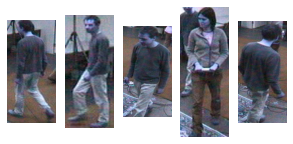

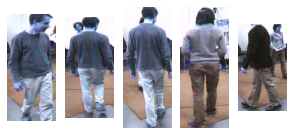

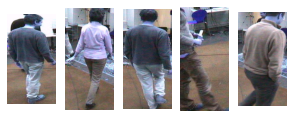

In [11]:
cam=0
ID=3
out_cams=[1,2,3]
N=5

candidates_cam_1 = candidates(reid_distance_matrix,label_to_idx, 
                                        idx_to_label, cam=cam, id=ID, N=N, 
                                        out_cam=out_cams[0])
candidates_cam_2 = candidates(reid_distance_matrix,label_to_idx, 
                                        idx_to_label, cam=cam, id=ID, N=N, 
                                        out_cam=out_cams[1])
candidates_cam_3 = candidates(reid_distance_matrix,label_to_idx, 
                                        idx_to_label, cam=cam, id=ID, N=N, 
                                        out_cam=out_cams[2])

candidates_cams = [candidates_cam_1, candidates_cam_2, candidates_cam_3]

print("        ##### QUERY #####")
print(" ")
print("Camera:{} ; ID:{}".format(cam,ID))
print(" ")
print("        ##### CANDIDATES #####")
print(" ")
for i, out_cam in enumerate(out_cams):
    cand_str = ' '.join(map(str, candidates_cams[i])) 
    print("ID candidates for cam {}: {}".format(out_cam, cand_str))
print("        ##### MATCHING CROPED IMAGES #####")
print(" ")
for i, out_cam in enumerate(out_cams):
    print("Image Candidates for cam {}".format(out_cam))
    # Get indices
    candidate_idx = []
    for cid in candidates_cams[i]:
        candidate_idx.append(label_to_idx[(out_cam,cid)])
    # Plot croped images
    crops = []
    for j in range(N):
        im_crop = all_crops[candidate_idx[j]]
        #im_crop = cams_crops[out_cam][candidate_idx[j]]
        crops.append(im_crop)
    functions.display_crops(crops)

        ##### QUERY #####
 
Camera:0 ; ID:3
 


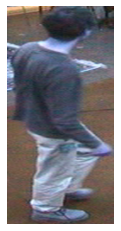

In [16]:
cam=0
ID=3

print("        ##### QUERY #####")
print(" ")
print("Camera:{} ; ID:{}".format(cam,ID))
print(" ")
crop = all_crops[label_to_idx[(cam,ID)]]

plt.axis('off')
plt.imshow(crop)
plt.show()

Application de l'algorithme du PCA pour essayer de visualiser **6** clusters distincts :

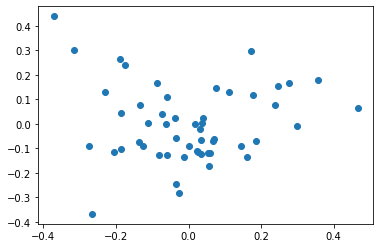

In [27]:
pca = PCA(n_components = 2)
pca_features = pca.fit_transform(all_features)

plt.figure()
plt.scatter(pca_features[:,0], pca_features[:,1])
plt.show()